# PHASE 1 - 14 Aug, 2025

# Dataset Interpretation – Cybersecurity Exercise Recommendation Project

## 1. Project Context
From the project description:
- **Goal:** Recommend cybersecurity exercises tailored to an organisation’s context, threats, and APT landscape.
- **Phase 1:** Build a baseline **item-based recommender** using **exercise metadata** (TTPs, threat groups, complexity, maturity, etc.) to find similar drills.
- **Datasets:**  
  - `orgs_full.csv` → Organisation profiles (**context**).  
  - `exercises_full.csv` → Exercise library (**content**).  
  - `ratings_train_full.csv` → Historical performance outcomes (**success metrics**).  

---

## 2. `orgs_full.csv` – Organisation Profiles
Each row = **one organisation** and its cyber posture.

| Column | Meaning in Project |
|--------|--------------------|
| **ORGID** | Unique org identifier; used to link with exercise history. |
| **Industry** | Sector or primary threat campaign type. |
| **Region** | Geographic location of the organisation. |
| **Size** | Organisation size (Small, Medium, Large). |
| **SecurityBudget** | Scale of investment (Low, Medium, High). |
| **PrimarySecurityTeam** | Security operation model (In-house, Outsourced, Hybrid). |
| **Maturity** | 1–5 score of the organisation’s overall **cybersecurity posture**. |
| **Complexity** | 1–5 score of IT/security environment complexity. |
| **ExerciseFrequency** | Number of cyber drills per year. |
| **Threats** | Types of threats most relevant to the organisation (semicolon-separated). |
| **TTPs** | MITRE ATT&CK techniques observed in their threat landscape. |
| **Aims** | High-level objectives (e.g., testing response to specific malware or APTs). |

**Interpretation:**  
- `Maturity` here = **org-wide cyber posture** (linked to security processes, not exercises).  
- Useful for clustering orgs based on **Threats, TTPs, and Aims** to discover archetypes (e.g., ransomware-prone orgs vs. insider-threat-prone).  

---

## 3. `exercises_full.csv` – Exercise Metadata
Each row = **one cyber training exercise**.

| Column | Meaning in Project |
|--------|--------------------|
| **EXID** | Unique exercise identifier. |
| **ExCreation** | Date/version of exercise creation. |
| **ExThreat** | Threat type simulated (Ransomware, Phishing, Trojan). |
| **ExTTPs** | MITRE ATT&CK techniques tested (semicolon-separated). |
| **ExCategories** | Higher-level tags (simulation, tabletop, malware, financial). |
| **ExGroups** | Associated adversary groups (Wizard Spider, APT29, FIN7). |
| **ExSoftware** | Tools/malware (Mimikatz, Cobalt Strike, TrickBot). |
| **ExStructure** | Structure (single-phase, multi-stage). |
| **ExMaturity** | 1–5 score of how realistic/advanced the scenario is. |
| **ExComplexity** | 1–5 score of difficulty/skill level required. |
| **ExLength** | Duration (minutes). |
| **ExAudience** | Targeted participants (SOC, management, hybrid). |
| **ExTradeCraftIntra** | Intra-technique skill richness. |
| **ExTradeCraftInter** | Cross-technique/multi-stage interconnectedness. |

**Interpretation:**  
- `ExMaturity` is different from org `Maturity`: here it represents **attack realism and impact**, closer to CVE severity.  
- Strongly tied to **TTP richness** and **tradecraft scores** (intra/inter).  

<div class="alert alert-block alert-warning">
    
**What “Intra-technique Tradecraft” is Intra = inside one tactic/technique.**
It measures how much detail and sophistication an exercise shows within a single MITRE ATT&CK technique or tactic.
**Example:**
Imagine an exercise simulating Credential Dumping.
- A low intra score (~0.1) might just show a simple mimic (e.g., “attacker runs mimikatz.exe once”).
- A high intra score (~0.8–1.0) would go deep:
    - multiple credential dumping sub-techniques (LSASS memory scrape, SAM database export, DCSync, etc.),
    - variations in tools (mimikatz, procdump, custom scripts),
    - evasion tricks (obfuscation, anti-AV bypass).

So, higher intra-tradecraft = the exercise digs deep into variants and tactics within a single path.

**Contrast with ExTradeCraftInter**

Inter = across multiple techniques/attack stages.
It measures how interconnected the exercise is — chaining different TTPs into a scenario.
**Example**
- A ransomware scenario might go:
- Phishing → Credential Access → Privilege Escalation → Exfiltration → Impact (encrypt).
That’s high inter-tradecraft (multi-stage, multi-technique).
</div>
---

## 4. `ratings_train_full.csv` – Performance Outcomes
Each row links an org with an exercise.

| Column | Meaning |
|--------|---------|
| **ORGID** | Organisation reference. |
| **EXID** | Exercise reference. |
| **ExerciseResults** | Numeric performance score. |
| **ExerciseRating** | Rating (1–5) of how well the org handled the exercise. |

**Interpretation:**  
- Provides the ground truth to **develop success metrics**.  
- Can evaluate whether org maturity correlates with better performance across exercises.  

---

## 5. How They Work Together
- **`orgs_full.csv`** = Context → what threats the org faces & what they want to prepare for.  
- **`exercises_full.csv`** = Content → library of available drills, defined by threat/TTPs/maturity.  
- **`ratings_train_full.csv`** = Outcomes → basis for metrics of success.  

**Phase 1 Workflow:**  
1. EDA:  
   - Compare org **Maturity (posture)** vs outcomes.  
   - Compare exercise **ExMaturity** vs TTP richness and tradecraft.  
   - Cluster orgs based on Threats/Groups/TTPs.  
2. Feature Engineering:  
   - Create a DTM from exercise metadata (TTPs, threats, groups, software, structure, audience).  
   - Add normalised numeric fields (`ExMaturity`, `ExComplexity`, `ExLength`, `ExTradeCraft*`).  
3. Similarity & Recommendation:  
   - Compute cosine similarity between exercises.  
   - Recommend new drills for an org, guided by similarity to past exercises.  
   - Explore tradecraft-based similarity metrics for richer recommendations.  


In [11]:
# Importing necesssary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the dataset
df_orgs = pd.read_csv("orgs_full.csv")
df_exs  = pd.read_csv("exercises_full.csv")

# Info and data types of the datasets & columns
df_orgs.info(), df_exs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ORGID                40 non-null     int64 
 1   Industry             40 non-null     object
 2   Region               40 non-null     object
 3   Size                 40 non-null     object
 4   SecurityBudget       40 non-null     object
 5   PrimarySecurityTeam  40 non-null     object
 6   Maturity             40 non-null     int64 
 7   Complexity           40 non-null     int64 
 8   ExerciseFrequency    40 non-null     int64 
 9   Threats              40 non-null     object
 10  TTPs                 40 non-null     object
 11  Aims                 40 non-null     object
dtypes: int64(4), object(8)
memory usage: 3.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  -----

(None, None)

In [12]:
df_orgs.head()

,ORGID,Industry,Region,Size,SecurityBudget,PrimarySecurityTeam,Maturity,Complexity,ExerciseFrequency,Threats,TTPs,Aims
0,1,Ransomware,South America,Small,Medium,In-house,4,4,120,Remote Access Trojan,Signed Binary Proxy Execution;Network Service ...,APT10;Maze;Supply Chain;Application Window Dis...
1,2,Supply Chain,Europe,Large,Medium,In-house,1,5,180,DDoS;Web Shell,Command and Scripting Interpreter;Service Stop...,XMRig;FIN7;Registry Run Keys;Cobalt Strike
2,3,Insider Threat,North America,Small,Medium,Outsourced,4,4,90,Banking Trojan;Ransomware;Crypto Miner,Data Exfiltration Over Web Service;Network Ser...,Remote Access Trojan;ASPXSpy;Remcos;Crypto Miner
3,4,Banking Trojan,Africa,Medium,Low,Hybrid,1,4,300,Phishing;Banking Trojan,Spearphishing Attachment;Signed Binary Proxy E...,Indicator Removal;Evilginx;NanoCore;Web Shell
4,5,Banking Trojan,Africa,Medium,High,In-house,4,5,180,Phishing,Data Staged;Unsecured Credentials;User Executi...,XMRig;njRAT;APT34;Command and Scripting Interp...


In [13]:
df_exs.head()

,EXID,ExCreation,ExThreat,ExTTPs,ExCategories,ExGroups,ExSoftware,ExStructure,ExMaturity,ExComplexity,ExLength,ExAudience,ExTradeCraftIntra,ExTradeCraftInter
0,1,2021-12-07,Ransomware,Credential Dumping;Process Injection;Access To...,Dark web;Malware,Wizard Spider;FIN6;TA505;UNC1878;DarkSide;REvi...,TrickBot,Notification;Response;Impact;Validation;Develo...,5,1,45,Network;SecOps,0.000000,0.750000
1,2,2023-07-02,Banking Trojan,Malicious File;Persistence;Valid Accounts,Data breach;Financial,Dridex Group;Evil Corp;Carbanak;Ursnif Operators,Dridex;TrickBot,Impact;Notification;Exfiltration;Detection;Med...,4,5,75,Media;SecOps,0.666667,1.000000
2,3,2022-12-26,Ransomware,Password Spraying;File and Directory Discovery...,Crypto;Impact,Wizard Spider;FIN6;TA505;UNC1878;DarkSide;REvi...,TrickBot;Maze,Exfiltration;Impact;Response;Validation;Media;...,2,5,30,Media;SecOps,0.000000,0.666667
3,4,2021-04-26,Remote Access Trojan;Crypto Miner,Drive-by Compromise;Credential Access;Maliciou...,C2;APT;Supply Chain,APT33;FIN7;APT41;APT3;Turla;Rocke;Panda;Blue M...,NanoCore;QuasarRAT;PlugX;XMRig;Kinsing;CoinMiner,Notification;Media;Developments;Response;Legal...,4,3,165,Network;SecOps,0.428571,0.714286
4,5,2022-10-20,Data Breach,Execution;Process Injection;Brute Force,Crypto;Botnet,APT29;FIN4;Charming Kitten;APT10;APT1;Cobalt G...,Empire;Mimikatz;BloodHound,Media;Exfiltration;Response;Detection;Validati...,1,5,150,Media;SecOps,0.333333,0.666667


# EDA

1. Checking missing values

In [14]:
# Checking missing values

print(df_orgs.isna().sum()) 
print()
print(df_exs.isna().sum())

ORGID                  0
Industry               0
Region                 0
Size                   0
SecurityBudget         0
PrimarySecurityTeam    0
Maturity               0
Complexity             0
ExerciseFrequency      0
Threats                0
TTPs                   0
Aims                   0
dtype: int64

EXID                 0
ExCreation           0
ExThreat             0
ExTTPs               0
ExCategories         0
ExGroups             0
ExSoftware           0
ExStructure          0
ExMaturity           0
ExComplexity         0
ExLength             0
ExAudience           0
ExTradeCraftIntra    0
ExTradeCraftInter    0
dtype: int64


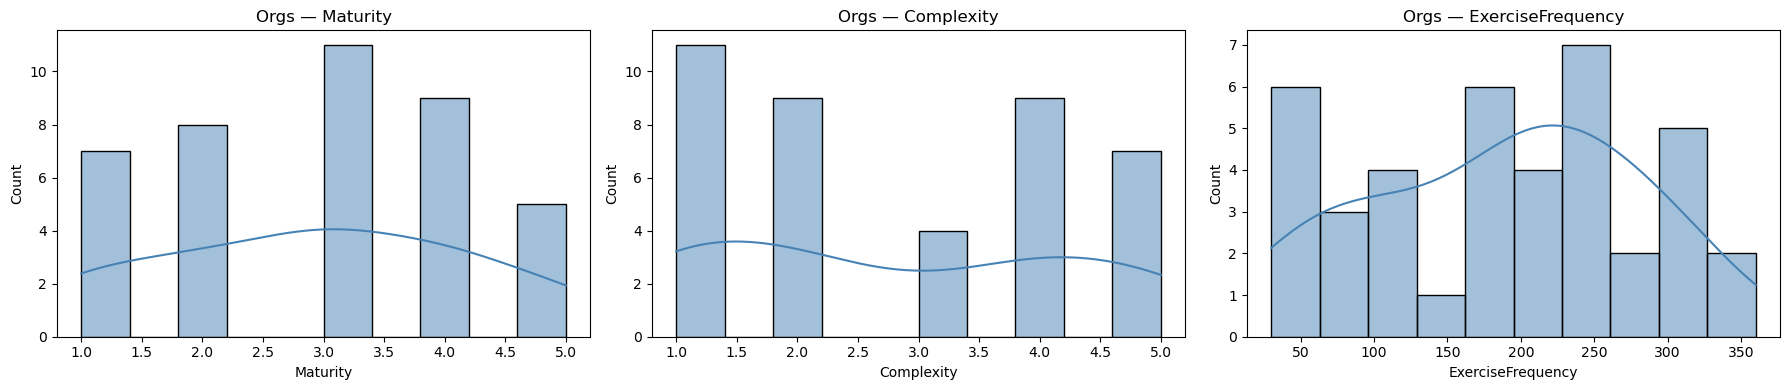

In [15]:
'''
orgs_full.csv has multiple numerical valriables like Maturity, Complexity, ExcerciseFrequency.
Lets see the numeric distribution of these features, This can also determine how the recommender 
will perform based on distribution of data.
'''

org_num = ["Maturity", "Complexity", "ExerciseFrequency"]

fig, axes = plt.subplots(1, len(org_num), figsize=(18, 4))  # 1 row, 3 columns

for ax, c in zip(axes, org_num):
    sns.histplot(df_orgs[c], kde=True, bins=10, color="steelblue", ax=ax)
    ax.set_title(f"Orgs — {c}")

plt.tight_layout()
plt.show()

## Interpretation

### For organisation Maturity
- We can say for maturity of organisation is failry balanced across level 1-5
- most organisation has maturity level 3 (mid-level)
- only few organisation has maturity level 5, meaning only few oraganisation has top-tier mature cyber posture

### For organisation Complexity
- Very few organisation has complexity at level 3
- The distribution seems skewed on left and right, suggesting either organisation has simple environment or very complex one. There are not many mid-level complexity.
  
### For organisation ExcersiceFrequency
- Some organisation performs 30 - 50 drills per year
- There is a large number cluster of organisation that does arounf 200 - 250 drills per year
- Only few organisation does 300+ drills per year

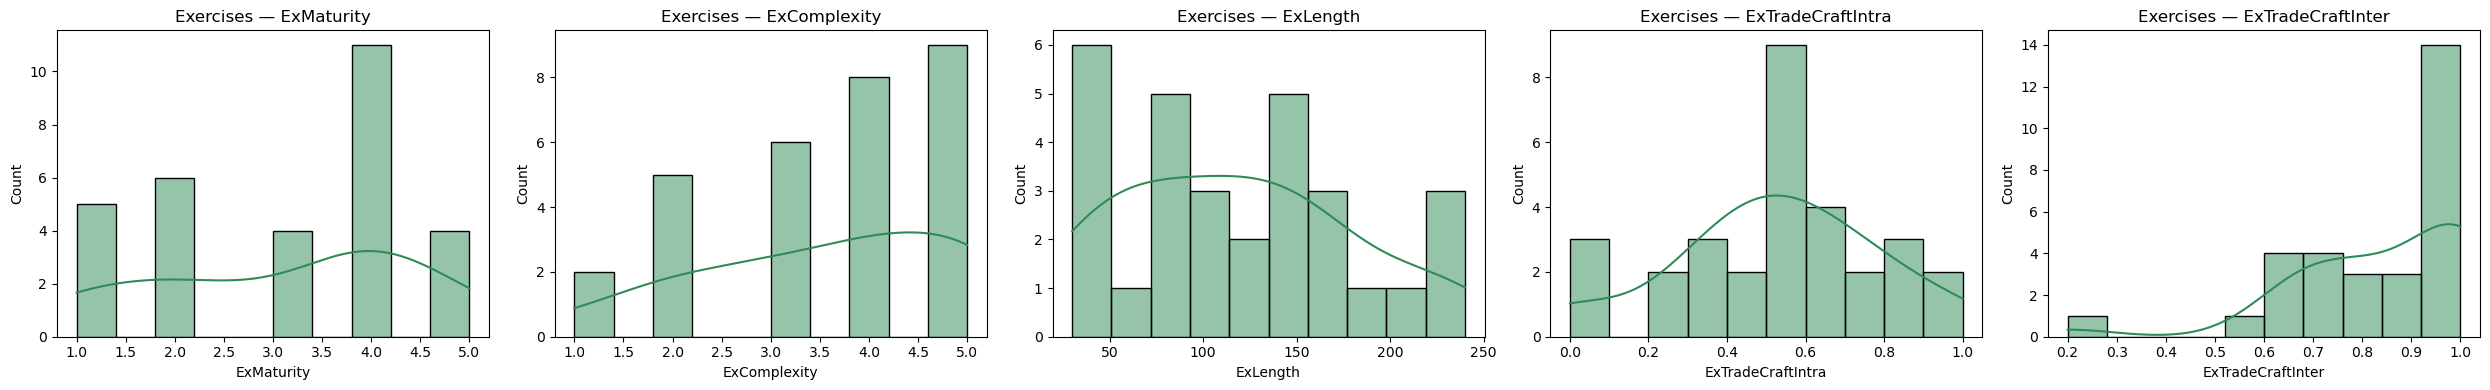

In [16]:
'''
excercises_full.csv also has multiple numerical valriables like ExMaturity, ExComplexity, 
ExLength, ExTradeCraftIntra and ExTradeCraftInter. Lets see the numeric distribution of 
these features. This can also determine how the recommender will perform based on distribution of data.
'''

ex_num = ["ExMaturity","ExComplexity","ExLength","ExTradeCraftIntra","ExTradeCraftInter"]

fig, axes = plt.subplots(1, len(ex_num), figsize=(25, 4))  # 1 row, 5 columns

for ax, c in zip(axes, ex_num):
    sns.histplot(df_exs[c], kde=True, bins=10, color="seagreen", ax=ax)
    ax.set_title(f"Exercises — {c}")

plt.tight_layout()
plt.show()


## Interpretation

### For excercise ExMaturity
- The largest cluster is at ExMaturity level 4 that suggest many exercises are designed as advace/mature level.
- Very few in compariation at the lowest level 1, suggesting the majority of excercises has higher level maturity.

### For excercise ExComplexity
- Data distribution slowly rises from level 1 to 5.
- Majority of the excercises has the complexity level 4 and 5.
  
### For excercise ExcersiceLength
- Range: ~30 minutes up to ~240 minutes.
- Many cluster between 60–150 mins.
- A few longer drills (>200 mins), but they’re rare.
- Most excercises are short-to-medium length. Long, marathon-style red-team drills are uncommon.
  
### For excercise ExcersiceTradeCraftIntra
- Range: 0 → 1 (as expected)
- Most cluster around 0.4–0.7
- A few near 0 or 1, but extremes are less common.
- Most exercises have a moderate level of intra tradecraft (depth within a single attack path).

### For excercise ExcersiceTradeCraftInter
- Strong skew: many exercises are ~0.9–1.0.
- Few below 0.5.
- Most excercises are highly interconnected across TTPs (multi-stage, chained attacks).
- This makes sense: advanced ransomware campaigns often blend discovery, persistence, exfiltration, etc.

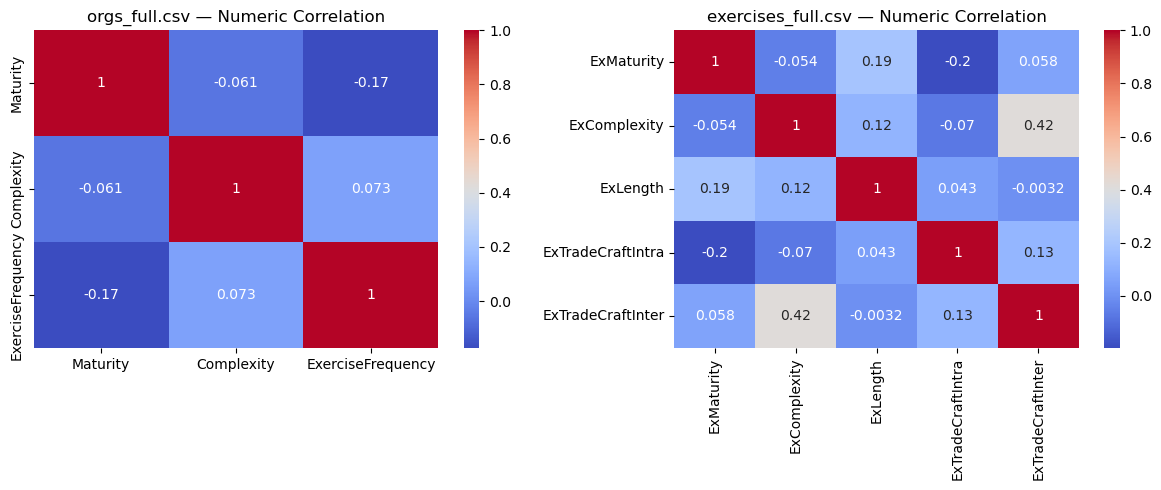

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Orgs correlation heatmap
sns.heatmap(df_orgs[org_num].corr(), annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title("orgs_full.csv — Numeric Correlation")

# Exercises correlation heatmap
sns.heatmap(df_exs[ex_num].corr(), annot=True, cmap="coolwarm", ax=axes[1])
axes[1].set_title("exercises_full.csv — Numeric Correlation")

plt.tight_layout()
plt.show()

## Interpretation

### Organisations

<div class="alert alert-block alert-info">
Maturity (orgs) = how advanced their cybersecurity posture is (processes, governance, training, etc.).
</div>

**Maturity vs Complexity → -0.061 → essentially no correlation.**
- Assumption: More complex organisations to also be more mature, but the data says that’s not guaranteed.
- Some orgs are mature but not complex (e.g., well-managed SMEs), others are complex but not mature (large orgs with poor posture).

**Maturity vs ExerciseFrequency → -0.17 → very weak negative correlation.**
- Surprisingly, orgs with higher maturity don’t necessarily run more exercises. In fact, some mature orgs train less often. Could be due to confidence in posture, or reliance on passive controls.

**Complexity vs ExerciseFrequency → +0.073 → almost no relationship.**
- Large/complex orgs don’t systematically run more drills than simple ones.

Org Maturity, Complexity, and ExerciseFrequency are independent. This means they each bring unique signals into your model.


### Excercises

**ExMaturity vs ExComplexity → -0.05 → no correlation.**
- Interesting: maturity and complexity aren’t the same. You can have a “realistic” but simple drill (e.g., common phishing), or a technically complex but less “mature” drill.

**ExMaturity vs ExLength → +0.19 (weak positive).**
- More mature exercises tend to be slightly longer, but not strongly so.

**ExComplexity vs ExLength → +0.12 (weak positive).**
- More complex exercises run a little longer, but again not strong.

**ExMaturity vs ExTradeCraftIntra → -0.20 (weak negative).**
- More mature exercises don’t necessarily go deeper into single-technique tradecraft — instead, they may focus on breadth.

**ExComplexity vs ExTradeCraftInter → +0.42 (moderate positive).**
- Complex exercises are more likely to chain together multiple TTPs. This makes sense: advanced attack chains require handling multiple interconnected tactics.

**ExTradeCraftIntra vs ExTradeCraftInter → +0.13 (very weak).**
- Internal depth and cross-technique chaining are mostly independent.

*Complexity ↔ Inter-tradecraft is the strongest relationship — multi-stage attack exercises are inherently harder.*
*Other correlations are weak, meaning each numeric field (ExMaturity, ExComplexity, ExLength, ExTradeCraft) adds distinct information. Good for DTM.*


# EDA on Categorical variables

- Top-10 values for each categorical field (most common threats, groups, TTPs, etc.).
- Distributions: are they dominated by a few values or balanced?
    - e.g., if 70% of exercises are “Ransomware”, our recommender might overfit to that.
- Richness: average number of TTPs per exercise/org.
    - This will later influence similarity weighting.

In [40]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def find_col(df: pd.DataFrame, col_like: str) -> str:
    """Find a column by name, case/underscore-insensitive."""
    target = re.sub(r'[^a-z0-9]', '', col_like.lower())
    for c in df.columns:
        cand = re.sub(r'[^a-z0-9]', '', c.lower())
        if cand == target:
            return c
    raise KeyError(f"Column like '{col_like}' not found. Available: {list(df.columns)}")

def normalize_explode(df: pd.DataFrame, col_like: str) -> pd.DataFrame:
    """
    Normalizes separators (; , |), lowercases, underscorizes tokens,
    explodes into tidy rows, and returns a (token, count) DataFrame.
    Works even if your source column is exthreat/ExThreat/ex_threat.
    """
    col = find_col(df, col_like)
    s = df[col].fillna("").astype(str).str.replace("|", ";").str.replace(",", ";")
    exploded = (s.str.split(";")
                  .explode()
                  .str.strip()
                  .str.lower()
                  .str.replace(" ", "_"))
    exploded = exploded[exploded != ""]
    # keep the original 'col' casing for the counts column name
    return exploded.value_counts().reset_index().rename(columns={"index": col, 0: "count"})

def plot_top(df_counts: pd.DataFrame, col_name: str | None = None, topk: int = 10,
             title: str | None = None, color: str = "steelblue", ax=None):
    """
    Plot the top-k counts. If col_name is None, use the first column (token column).
    If ax is provided, plot into that subplot; otherwise create a new figure.
    """
    if col_name is None:
        cols = [c for c in df_counts.columns if c != "count"]
        if not cols:
            raise ValueError("df_counts must contain a token column and 'count'.")
        col_name = cols[0]

    top = df_counts.head(topk)

    if ax is None:
        plt.figure(figsize=(7, 4))
        ax = plt.gca()

    sns.barplot(y=col_name, x="count", data=top, color=color, ax=ax)
    ax.set_title(title or f"Top {topk} {col_name}")
    ax.set_xlabel("Count")
    ax.set_ylabel("")


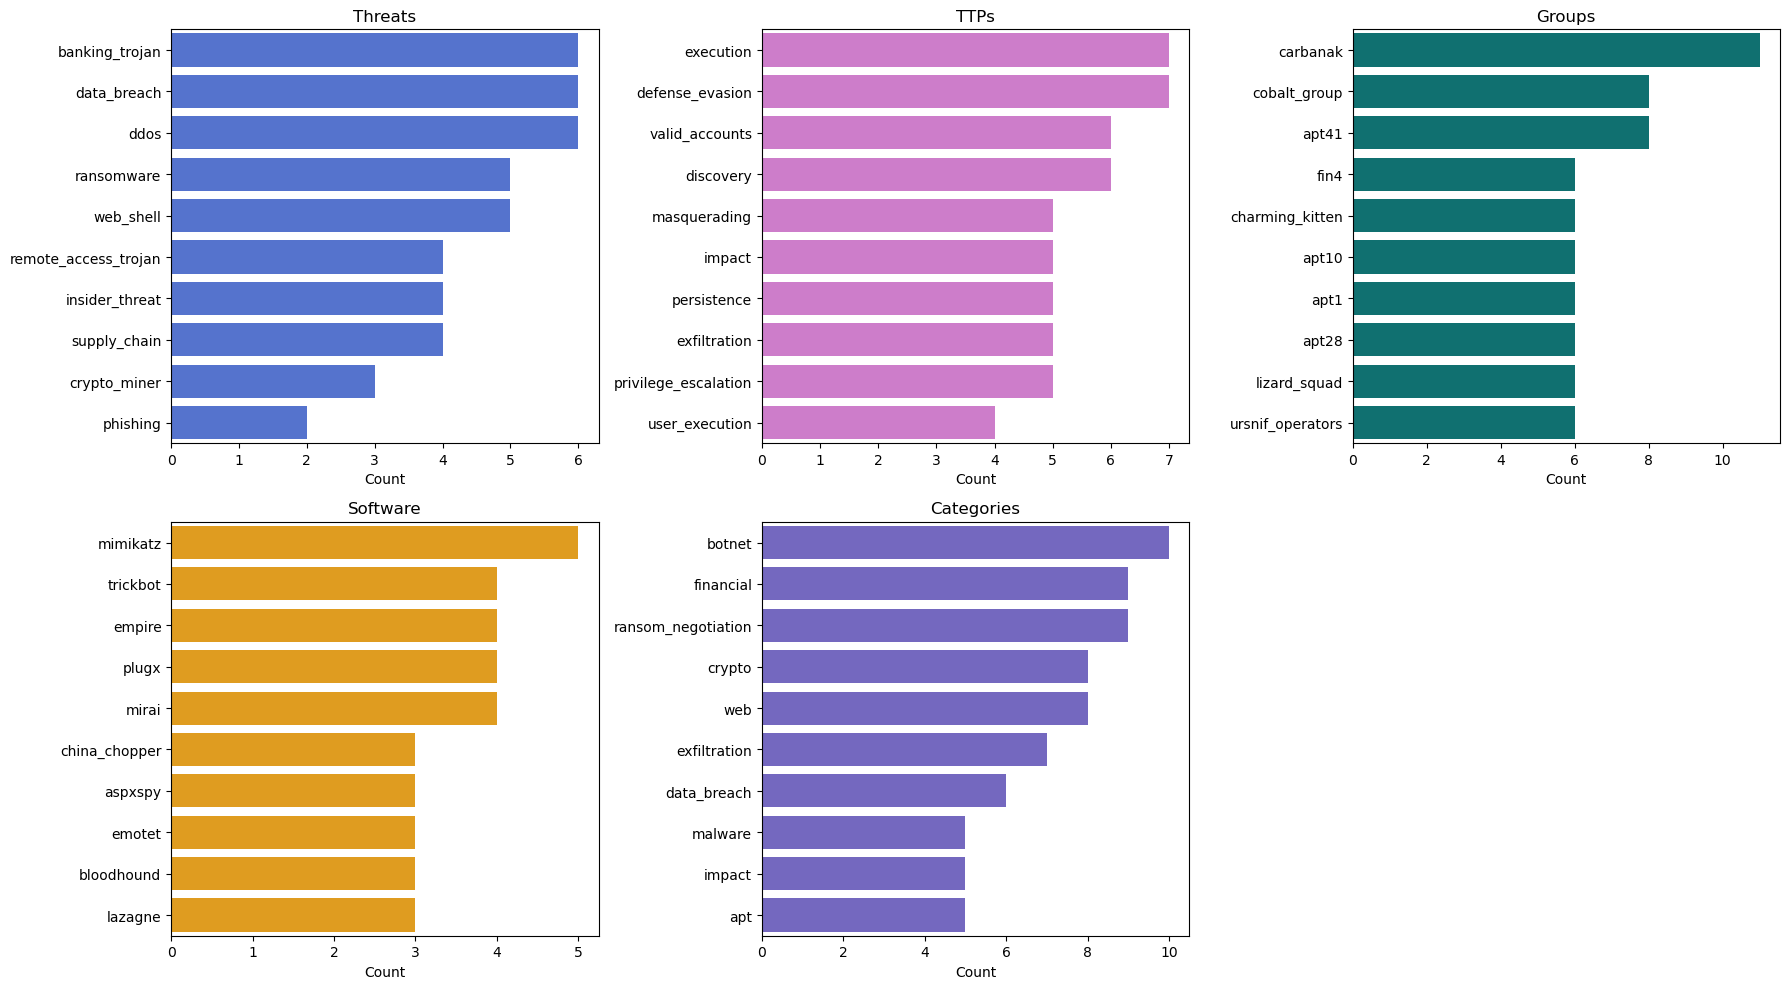

In [41]:
# Build counts
ex_threat_counts = normalize_explode(df_exs, "ExThreat")
ex_ttp_counts    = normalize_explode(df_exs, "ExTTPs")
ex_group_counts  = normalize_explode(df_exs, "ExGroups")
ex_soft_counts   = normalize_explode(df_exs, "ExSoftware")
ex_cat_counts    = normalize_explode(df_exs, "ExCategories")

# Plot into a grid
fig, axes = plt.subplots(2, 3, figsize=(18,10))

plot_top(ex_threat_counts, topk=10, title="Threats",    color="royalblue", ax=axes[0,0])
plot_top(ex_ttp_counts,    topk=10, title="TTPs",       color="orchid",   ax=axes[0,1])
plot_top(ex_group_counts,  topk=10, title="Groups",     color="teal",     ax=axes[0,2])
plot_top(ex_soft_counts,   topk=10, title="Software",   color="orange",   ax=axes[1,0])
plot_top(ex_cat_counts,    topk=10, title="Categories", color="slateblue",ax=axes[1,1])

axes[1,2].axis("off")  # hide last empty slot

plt.tight_layout()
plt.show()


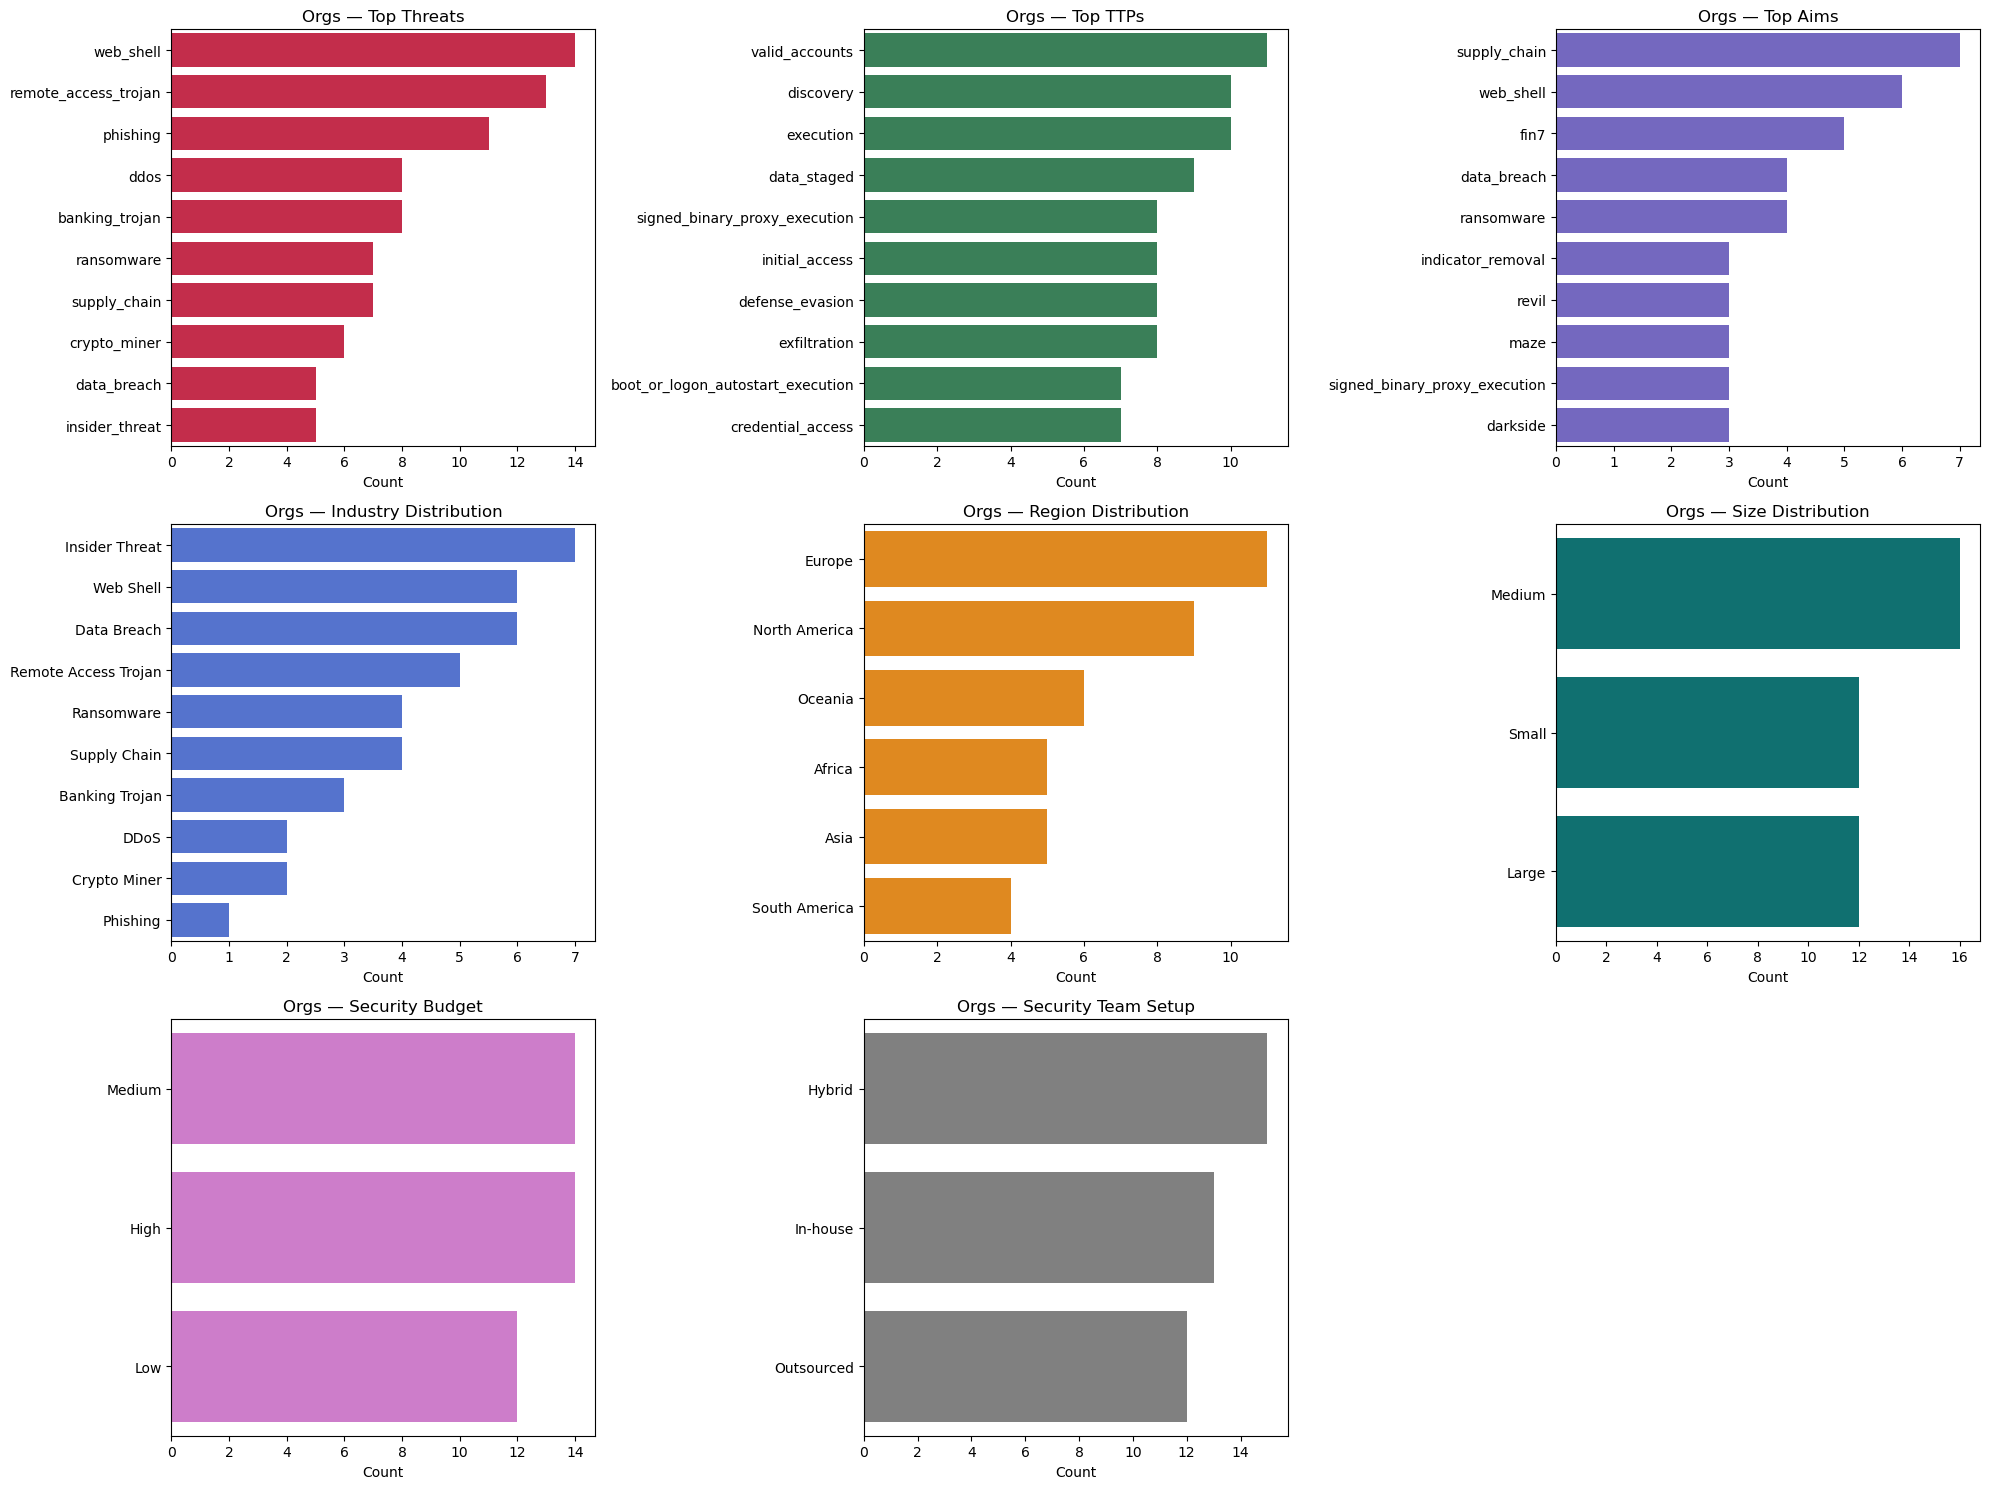

In [42]:
# Build counts
org_threat_counts   = normalize_explode(df_orgs, "Threats")
org_ttp_counts      = normalize_explode(df_orgs, "TTPs")
org_aim_counts      = normalize_explode(df_orgs, "Aims")

org_industry_counts = df_orgs["Industry"].value_counts().rename_axis("Industry").reset_index(name="count")
org_region_counts   = df_orgs["Region"].value_counts().rename_axis("Region").reset_index(name="count")
org_size_counts     = df_orgs["Size"].value_counts().rename_axis("Size").reset_index(name="count")
org_budget_counts   = df_orgs["SecurityBudget"].value_counts().rename_axis("SecurityBudget").reset_index(name="count")
org_team_counts     = df_orgs["PrimarySecurityTeam"].value_counts().rename_axis("PrimarySecurityTeam").reset_index(name="count")

# Plot into 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(20,15))
axes = axes.flatten()

plot_top(org_threat_counts,   topk=10, title="Orgs — Top Threats",          color="crimson", ax=axes[0])
plot_top(org_ttp_counts,      topk=10, title="Orgs — Top TTPs",             color="seagreen", ax=axes[1])
plot_top(org_aim_counts,      topk=10, title="Orgs — Top Aims",             color="slateblue", ax=axes[2])
plot_top(org_industry_counts, topk=10, title="Orgs — Industry Distribution",color="royalblue", ax=axes[3])
plot_top(org_region_counts,   topk=10, title="Orgs — Region Distribution",  color="darkorange", ax=axes[4])
plot_top(org_size_counts,     topk=10, title="Orgs — Size Distribution",    color="teal", ax=axes[5])
plot_top(org_budget_counts,   topk=10, title="Orgs — Security Budget",      color="orchid", ax=axes[6])
plot_top(org_team_counts,     topk=10, title="Orgs — Security Team Setup",  color="gray", ax=axes[7])

axes[8].axis("off")  # hide the last unused subplot

plt.tight_layout()
plt.show()


## Clustering the threats, ttps and aims in to cluster

In [43]:
# Combine Threats + TTPs + Aims into one token string per org
def combine_tokens(row):
    parts = []
    for col in ["Threats","TTPs","Aims"]:
        if pd.notna(row[col]):
            parts.append(str(row[col]))
    return ";".join(parts)

df_orgs["all_tokens"] = df_orgs.apply(combine_tokens, axis=1)
df_orgs["all_tokens"].head()

0    Remote Access Trojan;Signed Binary Proxy Execu...
1    DDoS;Web Shell;Command and Scripting Interpret...
2    Banking Trojan;Ransomware;Crypto Miner;Data Ex...
3    Phishing;Banking Trojan;Spearphishing Attachme...
4    Phishing;Data Staged;Unsecured Credentials;Use...
Name: all_tokens, dtype: object

In [44]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(tokenizer=lambda x: x.split(";"), binary=True)
X = vec.fit_transform(df_orgs["all_tokens"])

print("Matrix shape:", X.shape)  # rows = orgs, cols = unique tokens


Matrix shape: (40, 124)


/opt/homebrew/anaconda3/envs/cybersec-recsys/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())


In [46]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)  # choose k=4 (can adjust)
df_orgs["cluster"] = kmeans.fit_predict(X)

df_orgs[["ORGID","cluster"]].head()


,ORGID,cluster
0,1,3
1,2,3
2,3,2
3,4,3
4,5,3


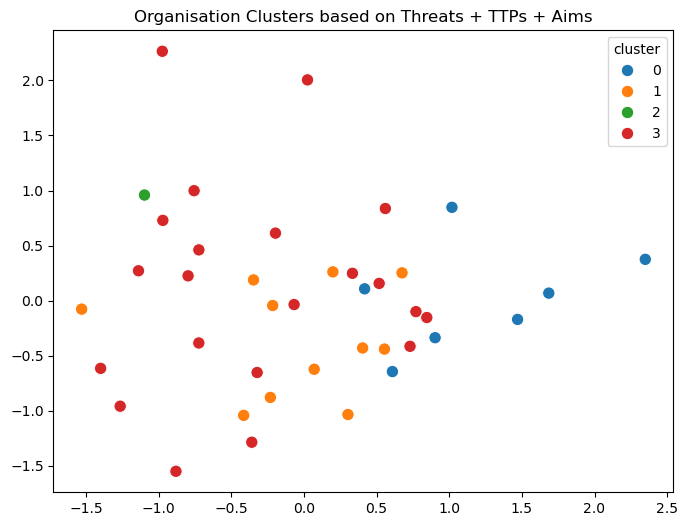

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=df_orgs["cluster"], palette="tab10", s=80)
plt.title("Organisation Clusters based on Threats + TTPs + Aims")
plt.show()


In [48]:
import pandas as pd

for c in sorted(df_orgs["cluster"].unique()):
    subset = df_orgs[df_orgs["cluster"]==c]
    tokens = ";".join(subset["all_tokens"])
    counts = pd.Series(tokens.split(";")).value_counts().head(10)
    print(f"\nCluster {c} (n={len(subset)}) top tokens:")
    print(counts)



Cluster 0 (n=7) top tokens:
Web Shell                        7
Remote Access Trojan             5
Exfiltration                     4
Credential Access                4
Signed Binary Proxy Execution    4
Account Manipulation             4
Rootkit                          3
Banking Trojan                   3
Phishing                         3
Insider Threat                   3
Name: count, dtype: int64

Cluster 1 (n=11) top tokens:
Web Shell                          8
Valid Accounts                     7
DDoS                               5
Supply Chain                       5
Data Breach                        5
Crypto Miner                       5
Execution                          5
Data Staged                        4
Initial Access                     4
Obfuscated Files or Information    4
Name: count, dtype: int64

Cluster 2 (n=1) top tokens:
Crypto Miner                          2
Banking Trojan                        1
Ransomware                            1
Data Exfiltration Ov

## Cluster 0 (7 orgs) → Advanced Malware / Credential Attack Focus

**Dominant tokens:** Web Shell, Remote Access Trojan, Credential Access, Exfiltration  
**Extra emphasis:** Account Manipulation, Rootkits, Banking Trojans  

**Interpretation:**  
These orgs are mainly worried about advanced malware that gains persistent access and steals credentials.  
They simulate *low-and-slow* intrusions where attackers remain inside the network and escalate privileges.  
**Likely industries:** Finance, tech — where credential compromise is a major concern.


## Cluster 1 (11 orgs) → Infrastructure & Supply Chain Threats

**Dominant tokens:** Web Shell, Valid Accounts, DDoS, Supply Chain, Data Breach, Crypto Miner  

**Interpretation:**  
These orgs face infrastructure-heavy attacks: denial-of-service, supply chain risks, and crypto-mining abuse.  
The presence of **Valid Accounts** shows they’re also worried about credential compromise as an entry vector.  
**Likely industries:** Service providers and cloud-heavy orgs — uptime, supply chain dependencies, and resource abuse are key worries.


## Cluster 2 (1 org — outlier) → Crypto-Mining Specialist Concern

**Dominant tokens:** Crypto Miner, Data Exfiltration over Web Service, Brute Force, Access Token Manipulation  

**Interpretation:**  
This org is a clear outlier (only 1 in the cluster).  
They focus on crypto-mining and brute-force account compromise.  
**Likely industries:** Energy, research, or cloud compute providers.  
This cluster probably needs to be **re-merged**, since one sample does not generalise well.


## Cluster 3 (21 orgs) → Social Engineering & Ransomware-Heavy

**Dominant tokens:** Phishing, Supply Chain, Remote Access Trojan, Ransomware  
**Secondary:** Web Shell, Malicious Files, Discovery  

**Interpretation:**  
This is the **largest cluster (21 orgs)** — the majority fall here.  
They focus on the classic ransomware kill chain: phishing → RAT → malicious file → discovery → ransomware.  
Supply chain threats are also strong here (Revil, Maze, FIN7 tokens).  
**Likely industries:** Mid- to large-sized organisations with mainstream ransomware exposure.


In [49]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack, csr_matrix
import re

def split_multi_cell(x: str):
    """Split a multi-valued string cell on ; , | then normalize (lower, underscore)."""
    if pd.isna(x):
        return []
    s = str(x)
    s = s.replace("|", ";").replace(",", ";")
    out = []
    for chunk in s.split(";"):
        t = chunk.strip()
        if t:
            out.append(re.sub(r"\s+", "_", t.lower()))
    return out

def join_prefixed_tokens(row, mapping):
    """
    mapping = [(col_name, prefix), ...]
    For each column in mapping, split and prefix tokens, return a space-joined string.
    """
    toks = []
    for col, pref in mapping:
        vals = split_multi_cell(row.get(col, ""))
        toks.extend([f"{pref}{v}" for v in vals])
    return " ".join(sorted(set(toks)))  # de-dup per row


In [50]:
# ORGS: main matching features + posture
org_cat_map = [
    ("Threats", "threat:"),
    ("TTPs",    "ttp:"),
    ("Aims",    "aim:"),
]
org_num_cols = ["Maturity"]  # you can add ["Complexity","ExerciseFrequency"] later if you want

# EXERCISES: content metadata + numeric descriptors
ex_cat_map = [
    ("ExThreat",     "threat:"),
    ("ExTTPs",       "ttp:"),
    ("ExGroups",     "group:"),
    ("ExSoftware",   "soft:"),
    ("ExCategories", "cat:"),
    ("ExAudience",   "aud:"),
    ("ExStructure",  "struct:"),
]
ex_num_cols = ["ExMaturity","ExComplexity","ExLength","ExTradeCraftIntra","ExTradeCraftInter"]


In [51]:
org_text = df_orgs.apply(lambda r: join_prefixed_tokens(r, org_cat_map), axis=1)
ex_text  = df_exs.apply(lambda r: join_prefixed_tokens(r, ex_cat_map), axis=1)

org_text.head(), ex_text.head()


(0    aim:application_window_discovery aim:apt10 aim...
 1    aim:cobalt_strike aim:fin7 aim:registry_run_ke...
 2    aim:aspxspy aim:crypto_miner aim:remcos aim:re...
 3    aim:evilginx aim:indicator_removal aim:nanocor...
 4    aim:apt34 aim:command_and_scripting_interprete...
 dtype: object,
 0    aud:network aud:secops cat:dark_web cat:malwar...
 1    aud:media aud:secops cat:data_breach cat:finan...
 2    aud:media aud:secops cat:crypto cat:impact gro...
 3    aud:network aud:secops cat:apt cat:c2 cat:supp...
 4    aud:media aud:secops cat:botnet cat:crypto gro...
 dtype: object)

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create DTM from categorical tokens
vec = TfidfVectorizer(tokenizer=lambda x: x.split(), binary=False)
X_cat = vec.fit_transform(ex_text)
print("Categorical DTM shape:", X_cat.shape)


Categorical DTM shape: (30, 185)


/opt/homebrew/anaconda3/envs/cybersec-recsys/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [64]:
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

ex_num_cols = ["ExMaturity","ExComplexity","ExLength",
               "ExTradeCraftIntra","ExTradeCraftInter"]

scaler =  MinMaxScaler()
X_num = scaler.fit_transform(df_exs[ex_num_cols])
print("Numeric feature matrix shape:", X_num.shape)


Numeric feature matrix shape: (30, 5)


In [61]:
from scipy.sparse import hstack, csr_matrix

# convert numeric to sparse so it stacks cleanly
X_num_sparse = csr_matrix(X_num)

# horizontally stack
X_combined = hstack([X_cat, X_num_sparse])
print("Final feature matrix shape:", X_combined.shape)


Final feature matrix shape: (30, 190)


In [100]:
from sklearn.metrics.pairwise import cosine_similarity

# pairwise similarities between exercises
sim_matrix = cosine_similarity(X_combined)



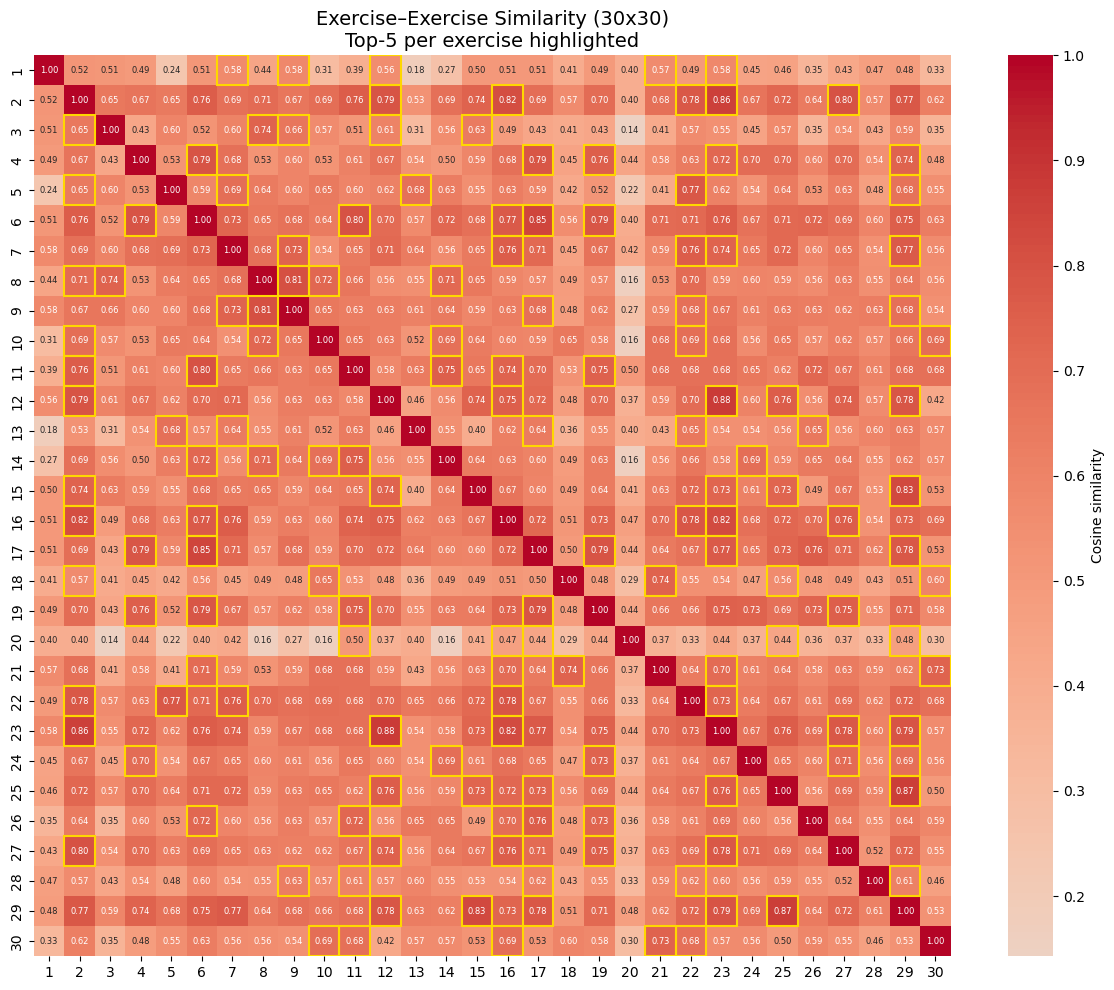

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assume sim_matrix is (30, 30)
n = sim_matrix.shape[0]
labels = df_exs["EXID"].astype(str).tolist() if "df_exs" in globals() else np.arange(n)

# --- 1. Find top-5 per row (excluding self=1.0) ---
highlight = np.zeros_like(sim_matrix, dtype=bool)
for i in range(n):
    row = sim_matrix[i].copy()
    row[i] = -np.inf            # ignore self-similarity
    top_idx = np.argsort(row)[-5:]  # top 5 indices
    highlight[i, top_idx] = True

# --- 2. Plot heatmap with annotations ---
plt.figure(figsize=(12, 10))
ax = sns.heatmap(sim_matrix,
                 xticklabels=labels,
                 yticklabels=labels,
                 cmap="coolwarm",
                 center=0,
                 annot=True, fmt=".2f",  # show values
                 annot_kws={"size":6},
                 cbar_kws={"label": "Cosine similarity"})

# --- 3. Overlay markers for top-5 similarities ---
for i in range(n):
    for j in range(n):
        if highlight[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False,
                                       edgecolor="gold", lw=1.5))

plt.title("Exercise–Exercise Similarity (30x30)\nTop-5 per exercise highlighted", fontsize=14)
plt.tight_layout()
plt.show()


In [89]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import chi2_kernel
import numpy as np

# counts from your space-separated, prefixed tokens
vec_count = CountVectorizer(tokenizer=lambda x: x.split())
X_cat_counts = vec_count.fit_transform(ex_text)

# L1-normalize rows → distributions
X_cat_dist = normalize(X_cat_counts, norm="l1")

# chi-square kernel expects dense
X_dense = X_cat_dist.toarray()   # or: np.asarray(X_cat_dist.todense())

chi_gamma = 0.5
sim_chi = chi2_kernel(X_dense, gamma=chi_gamma)  # (n_ex, n_ex), values in (0,1]


/opt/homebrew/anaconda3/envs/cybersec-recsys/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [90]:
import numpy as np

X = X_cat_counts.toarray()
# (optional but recommended) L1-normalize to distributions:
X = X / (X.sum(axis=1, keepdims=True) + 1e-12)

# pairwise chi-square distance
eps = 1e-12
num = (X[:, None, :] - X[None, :, :]) ** 2
den = (X[:, None, :] + X[None, :, :] + eps)
chi2_dist = 0.5 * np.sum(num / den, axis=2)            # (n,n)

# convert distance → similarity
gamma = 0.5
sim_chi = np.exp(-gamma * chi2_dist)                   # (n,n), (0,1]


In [91]:
import numpy as np

X = X_counts if isinstance(X_counts, np.ndarray) else X_counts.toarray()
eps = 1e-12

# Efficient pairwise χ² distance computation
# Expand dims for broadcasting: (n,1,d) vs (1,n,d)
num = (X[:, None, :] - X[None, :, :]) ** 2
den = (X[:, None, :] + X[None, :, :] + eps)
chi2_dist = 0.5 * np.sum(num / den, axis=2)  # shape (n, n)

# Option 1: min-max normalize to [0,1] similarity
mx = chi2_dist.max() if np.isfinite(chi2_dist).any() else 1.0
chi2_sim_mm = 1.0 - (chi2_dist / (mx + eps))

# Option 2: RBF-style similarity (closer to the kernel above)
gamma = 0.5
chi2_sim_rbf = np.exp(-gamma * chi2_dist)

# Use one of the similarities:
chi2_sim = chi2_sim_rbf


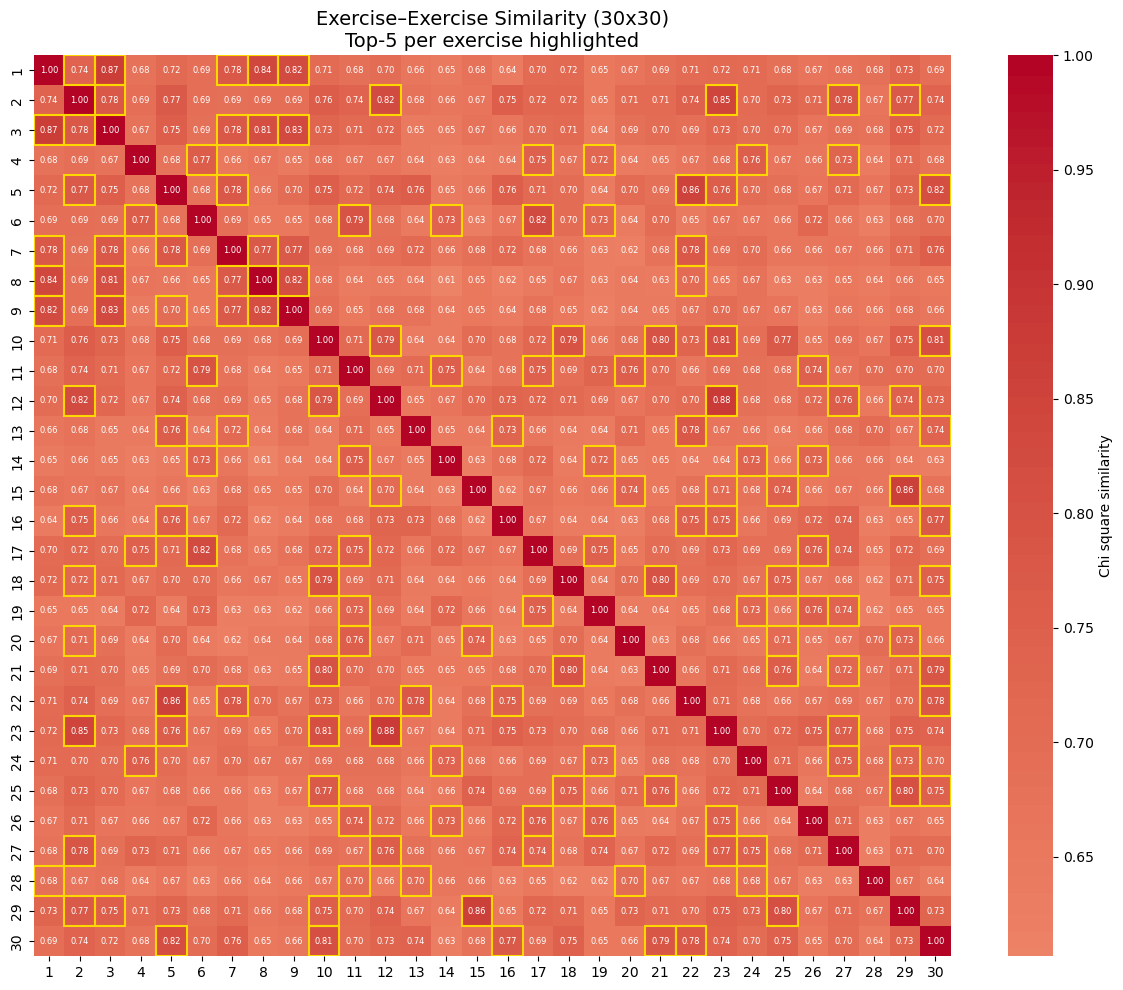

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assume sim_matrix is (30, 30)
n = sim_chi.shape[0]
labels = df_exs["EXID"].astype(str).tolist() if "df_exs" in globals() else np.arange(n)

# --- 1. Find top-5 per row (excluding self=1.0) ---
highlight = np.zeros_like(sim_chi, dtype=bool)
for i in range(n):
    row = sim_chi[i].copy()
    row[i] = -np.inf            # ignore self-similarity
    top_idx = np.argsort(row)[-5:]  # top 5 indices
    highlight[i, top_idx] = True

# --- 2. Plot heatmap with annotations ---
plt.figure(figsize=(12, 10))
ax = sns.heatmap(sim_chi,
                 xticklabels=labels,
                 yticklabels=labels,
                 cmap="coolwarm",
                 center=0,
                 annot=True, fmt=".2f",  # show values
                 annot_kws={"size":6},
                 cbar_kws={"label": "Chi square similarity"})

# --- 3. Overlay markers for top-5 similarities ---
for i in range(n):
    for j in range(n):
        if highlight[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False,
                                       edgecolor="gold", lw=1.5))

plt.title("Exercise–Exercise Similarity (30x30)\nTop-5 per exercise highlighted", fontsize=14)
plt.tight_layout()
plt.show()


In [98]:
import numpy as np
import pandas as pd

def topk_neighbors(sim_matrix, df_exs, k=5):
    results = {}
    for i in range(sim_matrix.shape[0]):
        row = sim_matrix[i].copy()
        row[i] = -np.inf  # ignore self
        top_idx = np.argsort(row)[::-1][:k]  # top-k
        results[df_exs.iloc[i]["EXID"]] = df_exs.iloc[top_idx]["EXID"].tolist()
    return results

# Cosine neighbours
cosine_neighbors = topk_neighbors(sim_matrix, df_exs, k=5)

# Chi-square neighbours
chi_neighbors = topk_neighbors(sim_chi, df_exs, k=5)

# Side-by-side comparison
comparison = []
for exid in df_exs["EXID"]:
    comparison.append({
        "EXID": exid,
        "Cosine_Top5": cosine_neighbors[exid],
        "ChiSquare_Top5": chi_neighbors[exid]
    })

df_compare = pd.DataFrame(comparison)


In [99]:
df_compare

,EXID,Cosine_Top5,ChiSquare_Top5
0,1,"[23, 9, 7, 21, 12]","[3, 8, 9, 7, 2]"
1,2,"[23, 16, 27, 12, 22]","[23, 12, 27, 3, 29]"
2,3,"[8, 9, 2, 15, 12]","[1, 9, 8, 7, 2]"
3,4,"[6, 17, 19, 29, 23]","[6, 24, 17, 27, 19]"
4,5,"[22, 7, 13, 29, 2]","[22, 30, 7, 2, 23]"
5,6,"[17, 11, 4, 19, 16]","[17, 11, 4, 14, 19]"
6,7,"[29, 22, 16, 23, 9]","[1, 5, 3, 22, 8]"
7,8,"[9, 3, 10, 14, 2]","[1, 9, 3, 7, 22]"
8,9,"[8, 7, 29, 17, 22]","[3, 1, 8, 7, 5]"
9,10,"[8, 2, 22, 30, 14]","[23, 30, 21, 18, 12]"
